# Time series forecasting

# Initial setup

## Import required packages

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Import time series data: Airline passenger traffic

In [2]:
data = pd.read_csv('sales-data.csv', header = None)
data.columns = ['Month','Sales']
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data = data.set_index('Month')
data.head(12)

,Sales
Month,
1980-01-01,154
1980-02-01,96
1980-03-01,73
1980-04-01,49
1980-05-01,36
1980-06-01,59
1980-07-01,95
1980-08-01,169
1980-09-01,219


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 77 entries, 1980-01-01 to 1986-05-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   77 non-null     int64
dtypes: int64(1)
memory usage: 1.2 KB


# Time series analysis

## Plot time series data

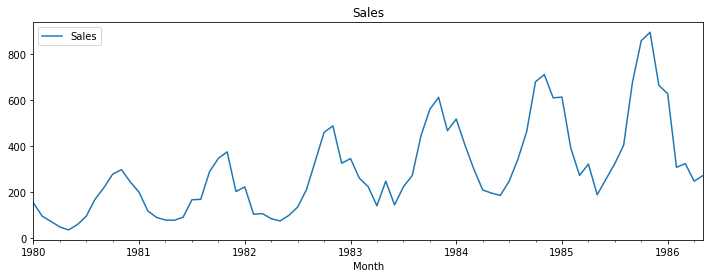

In [4]:
data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Sales')
plt.show(block=False)

## Outlier detection

### Box plot and interquartile range

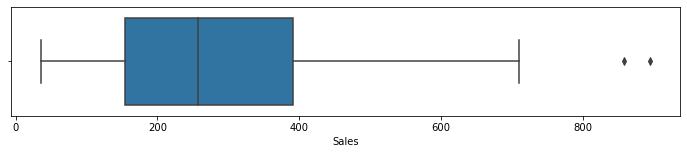

In [5]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=data['Sales'],whis=1.5)

### Histogram plot

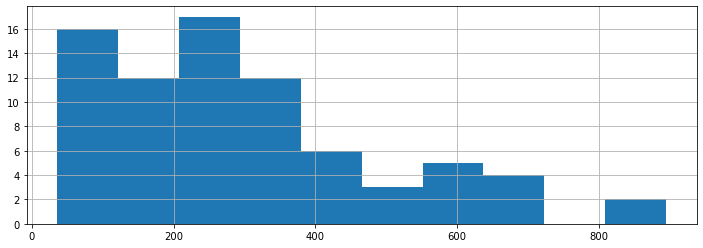

In [7]:
fig = data.Sales.hist(figsize = (12,4))

## Time series Decomposition

### Additive seasonal decomposition

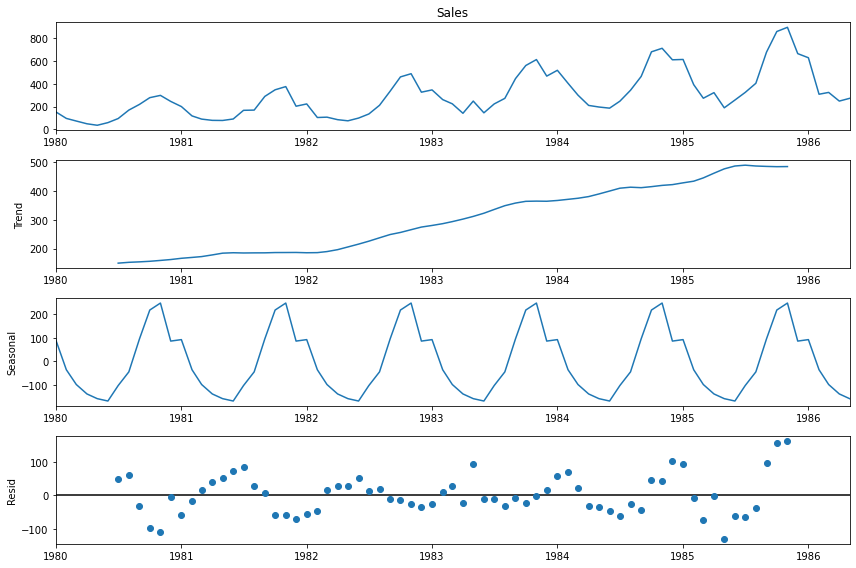

In [8]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(data.Sales, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

### Multiplicative seasonal decomposition

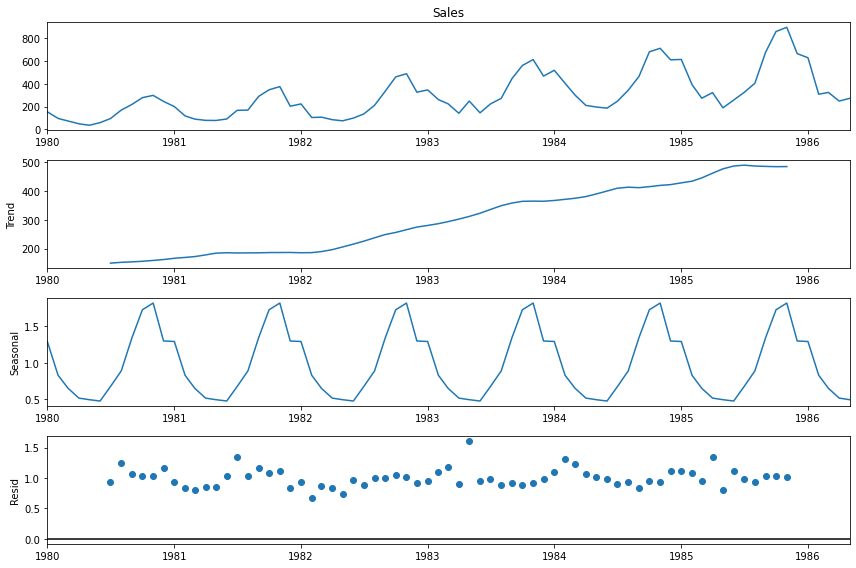

In [9]:
decomposition = sm.tsa.seasonal_decompose(data.Sales, model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

# Build and evaluate time series forecast

## Split time series data into training and test set

In [10]:
train_len = 60
train = data[0:train_len] # first 60 months as training set
test = data[train_len:] # last 17 months as out-of-time test set

In [11]:
train.shape

(60, 1)

In [12]:
test.shape

(17, 1)

# Simple time series methods

## Naive method

In [17]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['Sales'][train_len-1]

### Plot train, test and forecast

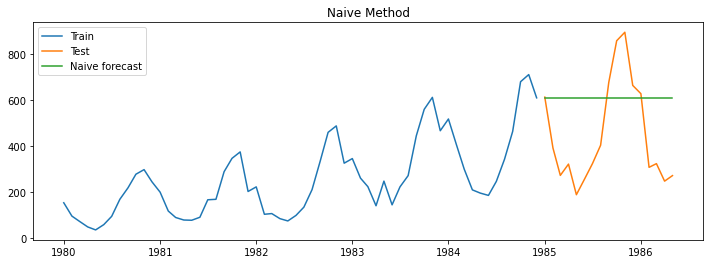

In [18]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

### Calculate RMSE and MAPE

In [19]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_naive['naive_forecast'])/test['Sales'])*100,2)

results = pd.DataFrame({'Method':['Naive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,269.95,76.86


## Simple moving average method

In [20]:
y_hat_sma = data.copy()
ma_window = 12
y_hat_sma['sma_forecast'] = data['Sales'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

### Plot train, test and forecast

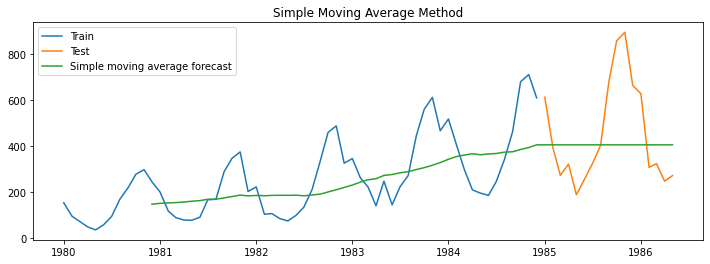

In [21]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

### Calculate RMSE and MAPE

In [22]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_sma['sma_forecast'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_sma['sma_forecast'][train_len:])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple moving average forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,269.95,76.86
0,Simple moving average forecast,221.78,41.27


# Exponential smoothing methods

## Simple exponential smoothing

In [23]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['Sales'])
model_fit = model.fit(optimized=True)
model_fit.params
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(17)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


### Plot train, test and forecast

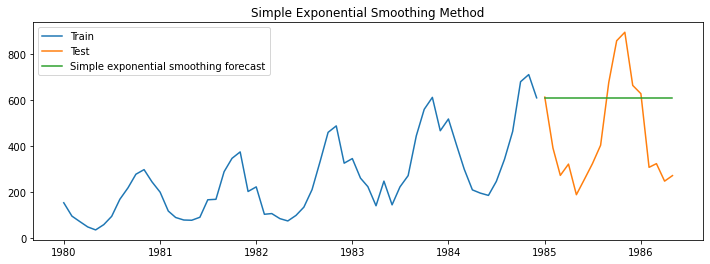

In [24]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

### Calculate RMSE and MAPE

In [25]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ses['ses_forecast'])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple exponential smoothing forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE
0,Naive method,269.95,76.86
0,Simple moving average forecast,221.78,41.27
0,Simple exponential smoothing forecast,269.95,76.86


# Auto Regressive methods

## Stationarity vs non-stationary time series

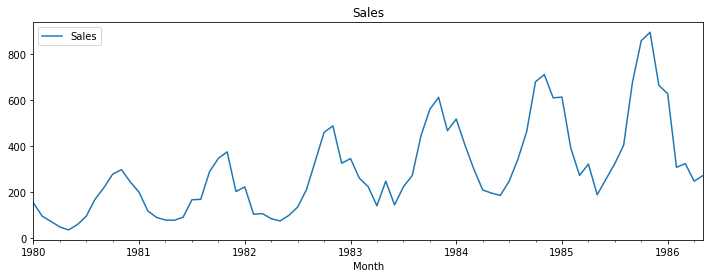

In [26]:
data['Sales'].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Sales')
plt.show(block=False)

### Augmented Dickey-Fuller (ADF) test

In [27]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data['Sales'])

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: 0.581906
Critical Values @ 0.05: -2.91
p-value: 0.987161


### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [28]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(data['Sales'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.657628
Critical Values @ 0.05: 0.46
p-value: 0.017397


### Box Cox transformation to make variance constant

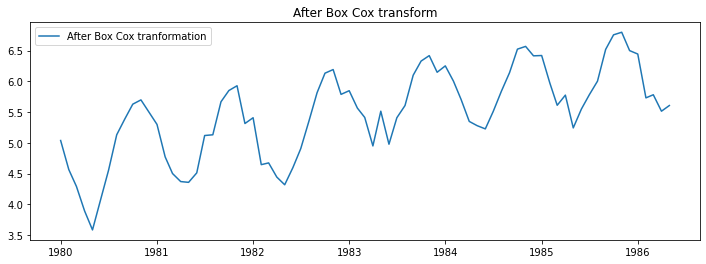

In [29]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data['Sales'], lmbda=0), index = data.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

### Differencing to remove trend

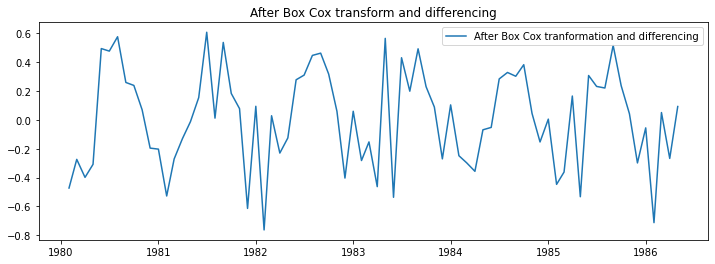

In [30]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), data.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [31]:
data_boxcox_diff.dropna(inplace=True)

In [32]:
data_boxcox_diff.tail()

Month
1986-01-01   -0.055742
1986-02-01   -0.712440
1986-03-01    0.050644
1986-04-01   -0.267315
1986-05-01    0.092373
dtype: float64

In [33]:
data_boxcox_diff.shape

(76,)

### Augmented Dickey-Fuller (ADF) test

In [34]:
adf_test = adfuller(data_boxcox_diff)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -8.348568
Critical Values @ 0.05: -2.91
p-value: 0.000000


### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [35]:
kpss_test = kpss(data_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.225247
Critical Values @ 0.05: 0.46
p-value: 0.100000


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


## Autocorrelation function (ACF)

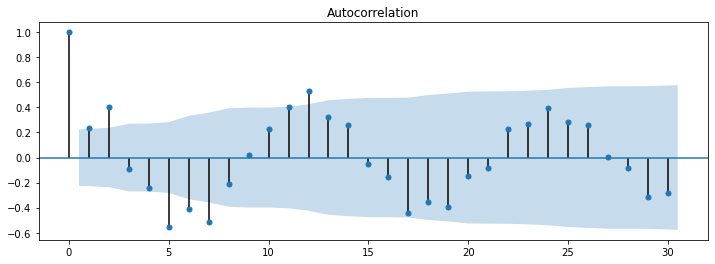

In [36]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(data_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

## Partial autocorrelation function (PACF)

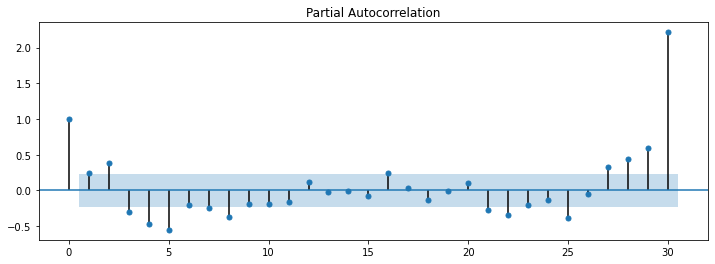

In [37]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

In [38]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

In [39]:
train_data_boxcox_diff

Month
1980-02-01   -0.472604
1980-03-01   -0.273889
1980-04-01   -0.398639
1980-05-01   -0.308301
1980-06-01    0.494019
1980-07-01    0.476339
1980-08-01    0.576022
1980-09-01    0.259173
1980-10-01    0.238549
1980-11-01    0.069472
1980-12-01   -0.195835
1981-01-01   -0.202941
1981-02-01   -0.527633
1981-03-01   -0.270875
1981-04-01   -0.130362
1981-05-01   -0.012739
1981-06-01    0.154151
1981-07-01    0.607134
1981-08-01    0.011905
1981-09-01    0.536528
1981-10-01    0.182898
1981-11-01    0.077601
1981-12-01   -0.613720
1982-01-01    0.093966
1982-02-01   -0.762781
1982-03-01    0.028438
1982-04-01   -0.230178
1982-05-01   -0.125163
1982-06-01    0.277632
1982-07-01    0.310155
1982-08-01    0.446583
1982-09-01    0.462272
1982-10-01    0.317096
1982-11-01    0.059089
1982-12-01   -0.403418
1983-01-01    0.059541
1983-02-01   -0.281918
1983-03-01   -0.152874
1983-04-01   -0.462886
1983-05-01    0.564669
1983-06-01   -0.536695
1983-07-01    0.430438
1983-08-01    0.198630
1983-

## Auto regression moving average method (ARMA)

In [41]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_data_boxcox_diff, order=(4, 0, 3))
model_fit = model.fit()
print(model_fit.params)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


const      0.019234
ar.L1.y    0.255273
ar.L2.y    1.094023
ar.L3.y   -0.640701
ar.L4.y   -0.482660
ma.L1.y   -0.807517
ma.L2.y   -0.767964
ma.L3.y    0.982467
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


In [42]:
data_boxcox_diff.index.max()

Timestamp('1986-05-01 00:00:00')

### Recover original time series

In [43]:
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

### Plot train, test and forecast

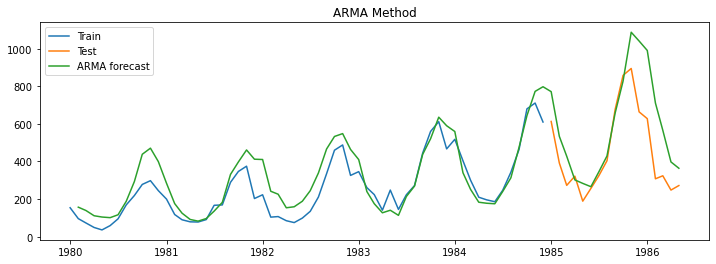

In [52]:
plt.figure(figsize=(12,4))
plt.plot( data['Sales'][:train_len], label='Train')
plt.plot(data['Sales'][train_len:], label='Test')
plt.plot(y_hat_arma['arma_forecast'], label='ARMA forecast')
plt.legend(loc='best')
plt.title('ARMA Method')
plt.show()

### Calculate RMSE and MAPE

In [53]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_arma['arma_forecast'][train_len-1:])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_arma['arma_forecast'][train_len-1:])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive moving average (ARMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,269.95,76.86
0,Simple moving average forecast,221.78,41.27
0,Simple exponential smoothing forecast,269.95,76.86
0,Autoregressive moving average (ARMA) method,194.63,37.27


## Auto regressive integrated moving average (ARIMA)

In [55]:
model = ARIMA(train_data_boxcox, order=(4, 1, 3))
model_fit = model.fit()
print(model_fit.params)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


const        0.019234
ar.L1.D.y    0.255273
ar.L2.D.y    1.094023
ar.L3.D.y   -0.640701
ar.L4.D.y   -0.482660
ma.L1.D.y   -0.807517
ma.L2.D.y   -0.767964
ma.L3.D.y    0.982467
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


### Recover original time series forecast

In [56]:
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

### Plot train, test and forecast

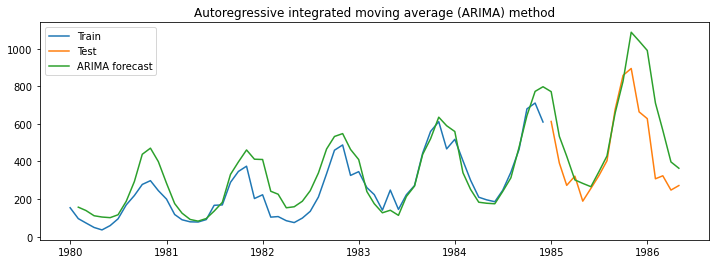

In [57]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_arima['arima_forecast'], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

### Calculate RMSE and MAPE

In [58]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_arima['arima_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive integrated moving average (ARIMA) method'],'RMSE': [rmse],'MAPE': [mape]})
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,269.95,76.86
0,Simple moving average forecast,221.78,41.27
0,Simple exponential smoothing forecast,269.95,76.86
0,Autoregressive moving average (ARMA) method,194.63,37.27
0,Autoregressive integrated moving average (ARIM...,194.63,37.27


## Seasonal auto regressive integrated moving average (SARIMA)

In [59]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(7, 2, 9), seasonal_order=(3, 1, 1, 12)) 
model_fit = model.fit()
print(model_fit.params)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ar.L1      -1.227854
ar.L2      -0.721538
ar.L3      -0.122847
ar.L4      -0.125527
ar.L5      -0.546151
ar.L6      -0.706925
ar.L7      -0.386173
ma.L1      -0.251145
ma.L2      -0.505619
ma.L3      -0.313097
ma.L4       0.325693
ma.L5       0.182845
ma.L6      -0.251743
ma.L7      -0.632805
ma.L8      -0.254917
ma.L9       0.714825
ar.S.L12   -0.419039
ar.S.L24   -0.256257
ar.S.L36   -0.662718
ma.S.L12   -0.234657
sigma2      0.017074
dtype: float64


### Recover original time series forecast

In [60]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

### Plot train, test and forecast

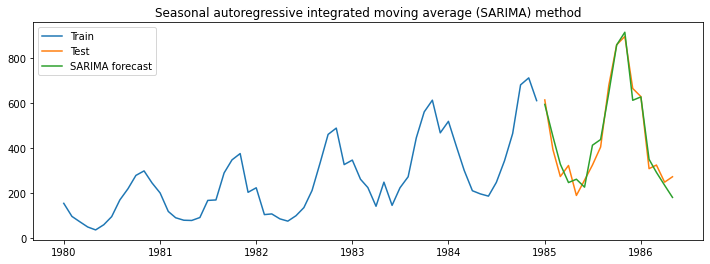

In [63]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

### Calculate RMSE and MAPE

In [64]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,269.95,76.86
0,Simple moving average forecast,221.78,41.27
0,Simple exponential smoothing forecast,269.95,76.86
0,Autoregressive moving average (ARMA) method,194.63,37.27
0,Autoregressive integrated moving average (ARIM...,194.63,37.27
0,Seasonal autoregressive integrated moving aver...,50.38,13.26
